# Section 1

Analyses for Section 1 of the Manuscript.

In this notebook, we look whether complex models (transformers) can achieve a higher performance.

With SN10 we achieved 98% on vs Non-binder and 90% on vs Weak.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1) Adequate choice of parameters? Overfitting?

Task HIGH_VS_LOOSER__3VRL__auto__0__42 not found in transformer_parameterset_1412af2e
Task HIGH_VS_95LOW__1ADQ__auto__0__42 not found in transformer_parameterset_1412af2e


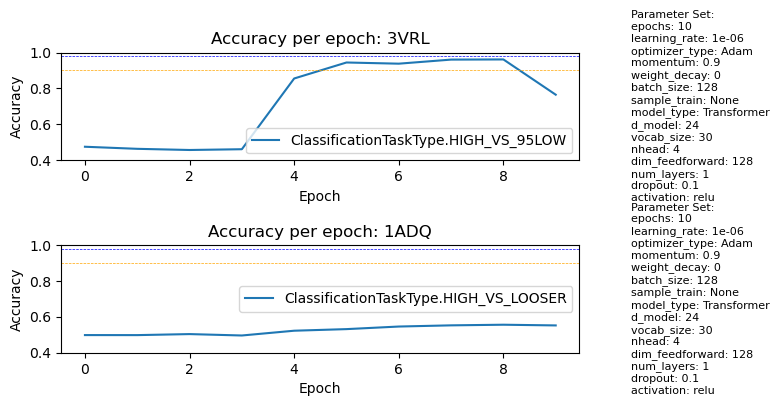

In [ ]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML_Transformer_Parameters_Absolut"

antigens = ["HR2P"]

task_types = [
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
]

seed_id = 0
split_id = 42

# Sort base_p.glob("*") based on creation date of directory
# This way we can plot the most recent runs first
sorted_dirs = sorted(base_p.glob("*"), key=lambda x: x.stat().st_ctime, reverse=True)

for parameterset_dir in sorted_dirs:
    
    dir_name = parameterset_dir.name
    loader = datasets.FrozenMiniAbsolutMLLoader(
        data_dir=parameterset_dir,
    )

    # Get parameter set
    with open(parameterset_dir / "parameter_set.json", "r") as f:
        parameters = json.load(f)

    fig, axs = plt.subplots(nrows=2)
    for ag, ax in zip(["3VRL", "1ADQ"], axs):
        for task_type_i in task_types:
            task = datasets.ClassificationTask(
                task_type=task_type_i,
                ag_pos=ag,
                ag_neg="auto",
                seed_id=seed_id,
                split_id=split_id,
                )

            try:                    
                task = loader.load(task, load_model=True)
            except ValueError:
                print(f"Task {task} not found in {dir_name}")
                continue

            online_metrics_json_fp = list((task.basepath / "epochs").glob("*"))[0]

            # Open json
            with open(online_metrics_json_fp, "r") as f:
                online_metrics = json.load(f)

            acc_per_epoch = []
            for d in online_metrics:
                acc_per_epoch.append(d["test_metrics"]["acc_closed"])

            # Plot accuracy per epoch
            ax.plot(acc_per_epoch, label=task_type_i)
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Accuracy")
            ax.set_title(f"Accuracy per epoch, {dir_name}")
            ax.legend()

            # Add text to the right of the plot
            # with the parameter set
            text = "Parameter Set:\n" + "\n".join([f"{k}: {v}" for k, v in parameters.items()])
            ax.text(1.1, 0.5, text, transform=ax.transAxes, fontsize=8, verticalalignment='center')

            ax.set_ylim(0.4, 1)


            # Mark 2 horizontal lines corresponding to performance of SN10
            ax.axhline(0.98, color="blue", linestyle="--", linewidth=0.5)
            ax.axhline(0.90, color="orange", linestyle="--", linewidth=0.5)

            ax.set_title(f"Accuracy per epoch: {ag}")
        
    # Set smaller size for the whole plot
    fig.set_size_inches(8, 4)
    fig.tight_layout()